## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/GEE_SO2/

Mounted at /gdrive
/gdrive/My Drive/GEE_SO2


## ⚙️ Import Libraries

In [ ]:
!pip install rasterio matplotlib geopandas ipywidgets folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.9 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import ipywidgets as widgets
from IPython.display import display

## ⏳ Load the Data

In [ ]:
# Set data path and years
data_dir = '/gdrive/My Drive/GEE_SO2/'
years = [2019, 2020, 2021, 2022, 2023]
file_template = data_dir + 'SO2_Daily_Multiband_{}.tif'

## 1. Visualize data for each day over 5 years(2 sliders)

In [ ]:
# 1. Read all years' data
all_bands = {}
for year in years:
    with rasterio.open(file_template.format(year)) as src:
        bands = src.read()  # shape: (num_bands, height, width)
        all_bands[year] = bands

# 2. Get number of days per year (auto-adapt)
days_per_year = {year: all_bands[year].shape[0] for year in years}

# 3. Compute global 99th percentile for colorbar vmax
all_values = np.concatenate([all_bands[year].flatten() for year in years])
global_vmax = np.nanpercentile(all_values, 99)

# 4. Visualization function
def show_band(year, day):
    bands = all_bands[year]
    band = bands[day - 1]
    plt.figure(figsize=(10, 6))
    plt.imshow(band, cmap='turbo', vmin=0, vmax=global_vmax)
    plt.title(f'SO₂ - {year} Day {day}')
    plt.colorbar(label='SO₂ Density')
    plt.figtext(0.5, -0.08, 'Region: Northern Italy, Po River Plain', ha='center', va='center', fontsize=14)
    plt.axis('off')
    plt.show()

# 5. Create sliders
year_slider = widgets.SelectionSlider(
    options=years, value=years[0], description='Year', continuous_update=False
)

def update_day_slider(*args):
    year = year_slider.value
    day_slider.max = days_per_year[year]
    if day_slider.value > day_slider.max:
        day_slider.value = 1

day_slider = widgets.IntSlider(
    min=1, max=days_per_year[years[0]], step=1, value=1, description='Day'
)
year_slider.observe(update_day_slider, names='value')

ui = widgets.HBox([year_slider, day_slider])
out = widgets.interactive_output(show_band, {'year': year_slider, 'day': day_slider})

display(ui, out)

Output()

## 2. Visualize data for each day over 5 years(1 sliders for 1826 days)

In [ ]:
# 1. Read all years' data and concatenate
all_bands = []
days_per_year = []
for year in years:
    with rasterio.open(file_template.format(year)) as src:
        bands = src.read()  # shape: (num_bands, height, width)
        all_bands.append(bands)
        days_per_year.append(bands.shape[0])

# 2. Synthesis (total_days, height, width)
bands_concat = np.concatenate(all_bands, axis=0)
total_days = bands_concat.shape[0]

# 3. Calculate the global 99th percentile maximum
global_vmax = np.nanpercentile(bands_concat, 99)

# 4. Calculate the year and the number of days in that year for each day
day_to_year = []
for i, days in enumerate(days_per_year):
    day_to_year += [(years[i], d+1) for d in range(days)]

# 5. Visualization function
def show_long_series(day):
    band = bands_concat[day-1]
    year, day_in_year = day_to_year[day-1]
    plt.figure(figsize=(10, 6))
    plt.imshow(band, cmap='turbo', vmin=0, vmax=global_vmax)
    plt.title(f'SO₂ - {year} Day {day_in_year} (Global Day {day})')
    plt.colorbar(label='SO₂ Density')
    plt.axis('off')
    plt.figtext(0.5, -0.08, 'Region: Northern Italy, Po River Plain', ha='center', va='center', fontsize=14)
    plt.show()

# 6. Create slider
slider = widgets.IntSlider(min=1, max=total_days, step=1, value=1, description='Day')
out = widgets.interactive_output(show_long_series, {'day': slider})

display(slider, out)

IntSlider(value=1, description='Day', max=1826, min=1)

Output()

## 3. SO₂ 5-Year Combined Gap Map (2019–2023)

2019 bands: (365, 300, 621)
2020 bands: (366, 300, 621)
2021 bands: (365, 300, 621)
2022 bands: (365, 300, 621)
2023 bands: (365, 300, 621)


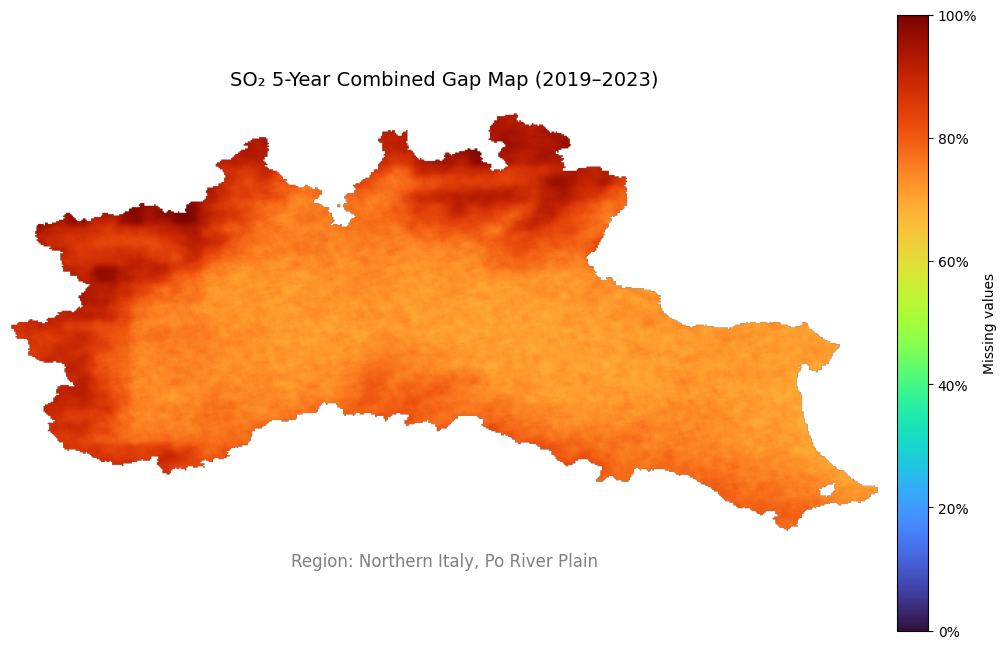


=== 5-Year Gap Statistics ===
Total days: 1826
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.774 (77.4%)
Median missing rate: 0.749 (74.9%)
Standard deviation: 0.068
90th percentile: 0.889 (88.9%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 73.1%
Very High (≥80%): 26.9%

=== Files Saved ===
PNG file: SO2_5Year_Gap_Map_2019_2023.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
from rasterio.features import geometry_mask

# Define years and file template
years = [2019, 2020, 2021, 2022, 2023]
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

# Initialize variables
sum_gap = None
total_days = 0

# Iterate over each year and calculate missing statistics
for year in years:
    file_path = file_template.format(year)
    with rasterio.open(file_path) as src:
        bands = src.read()  # shape: (days, height, width)
        print(f"{year} bands:", bands.shape)

        mask = (bands <= 0) | np.isnan(bands)  # 0 or nan is considered missing
        yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel per year

        if sum_gap is None:
            sum_gap = yearly_gap
        else:
            sum_gap += yearly_gap

        total_days += bands.shape[0]

# Calculate the missing rate
gap_ratio_5yr = sum_gap / total_days

# Get spatial range and create AOI mask
with rasterio.open(file_template.format(2023)) as src:
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Apply AOI mask to the gap ratio
masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio_5yr)

# Calculate basic statistics
total_pixels_aoi = np.sum(aoi_mask)  # Total pixels in AOI

# Get valid data for statistics
valid_data = masked_gap_aoi.compressed()

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
total_valid_pixels = len(valid_data)
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Drawing
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(masked_gap_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)

# Colorbar is placed on the right to avoid blocking the text
cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

# Statistics are only printed to console, not displayed on the map

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

# Titles and Notes
ax.set_title("SO₂ 5-Year Combined Gap Map (2019–2023)", fontsize=14, pad=20)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_5Year_Gap_Map_2019_2023.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== 5-Year Gap Statistics ===")
print(f"Total days: {total_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_5Year_Gap_Map_2019_2023.png (300 DPI)")

## 4. SO₂ Missing Value Map (2019)

2019 bands: (365, 300, 621)


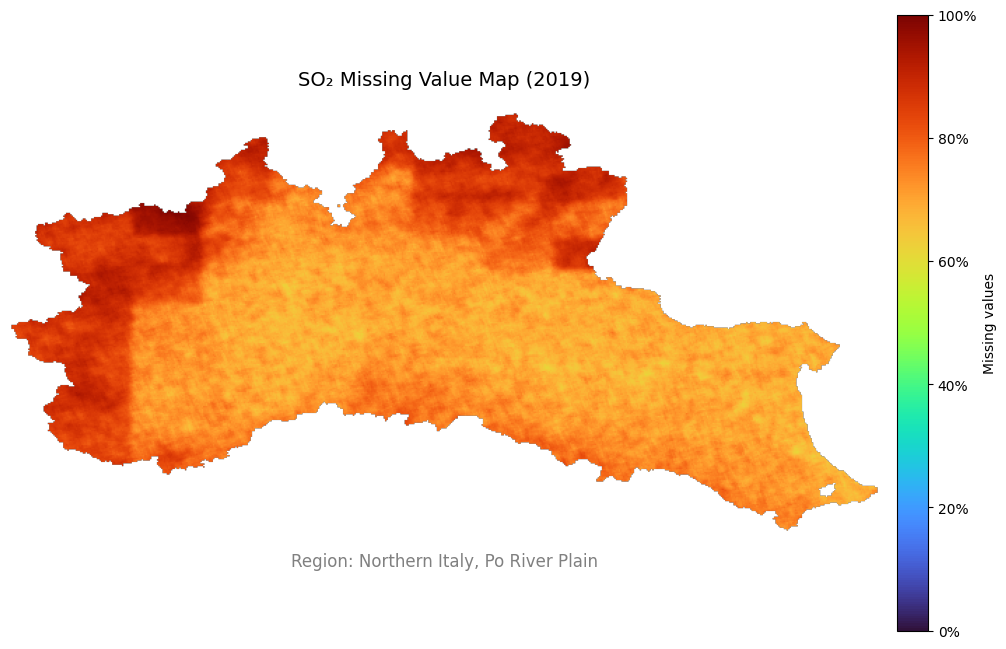


=== 2019 Gap Statistics ===
Total days: 365
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.751 (75.1%)
Median missing rate: 0.723 (72.3%)
Standard deviation: 0.075
90th percentile: 0.874 (87.4%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 74.5%
Very High (≥80%): 25.5%

=== Files Saved ===
PNG file: SO2_Missing_Value_Map_2019.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask

# Define file template
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

year = 2019
file_path = file_template.format(year)
with rasterio.open(file_path) as src:
    bands = src.read()  # shape: (days, height, width)
    print(f"{year} bands:", bands.shape)

    # 0 or nan is considered missing
    mask = (bands <= 0) | np.isnan(bands)
    yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel in 2019
    total_days = bands.shape[0]
    gap_ratio = yearly_gap / total_days   # Missing rate per pixel

    # Get spatial range and create AOI mask
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Apply AOI mask to the gap ratio
masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

# Calculate statistics
valid_data = masked_gap_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Drawing
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(masked_gap_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

ax.set_title("SO₂ Missing Value Map (2019)", fontsize=14, pad=20)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Missing_Value_Map_2019.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== 2019 Gap Statistics ===")
print(f"Total days: {total_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Missing_Value_Map_2019.png (300 DPI)")

## 5. SO₂ Missing Value Map (2020)

2020 bands: (366, 300, 621)


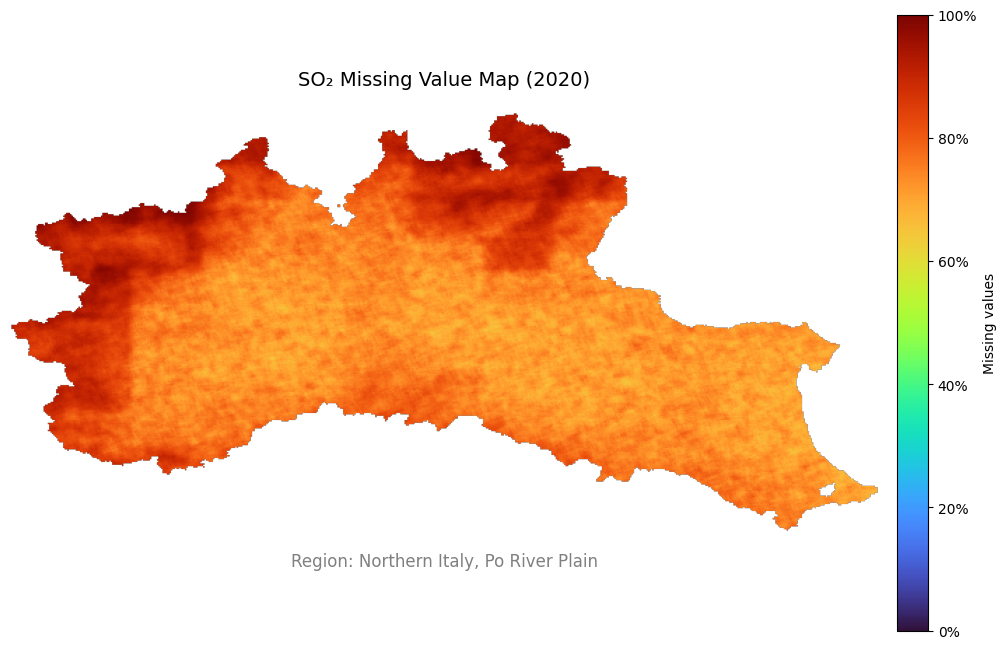


=== 2020 Gap Statistics ===
Total days: 366
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.772 (77.2%)
Median missing rate: 0.746 (74.6%)
Standard deviation: 0.074
90th percentile: 0.896 (89.6%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 72.3%
Very High (≥80%): 27.7%

=== Files Saved ===
PNG file: SO2_Missing_Value_Map_2020.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask

# Define file template
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

year = 2020
file_path = file_template.format(year)
with rasterio.open(file_path) as src:
    bands = src.read()  # shape: (days, height, width)
    print(f"{year} bands:", bands.shape)

    # 0 or nan is considered missing
    mask = (bands <= 0) | np.isnan(bands)
    yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel in 2020
    total_days = bands.shape[0]
    gap_ratio = yearly_gap / total_days   # Missing rate per pixel

    # Get spatial range and create AOI mask
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Apply AOI mask to the gap ratio
masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

# Calculate statistics
valid_data = masked_gap_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Drawing
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(masked_gap_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

ax.set_title("SO₂ Missing Value Map (2020)", fontsize=14, pad=20)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Missing_Value_Map_2020.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== 2020 Gap Statistics ===")
print(f"Total days: {total_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Missing_Value_Map_2020.png (300 DPI)")

## 6. SO₂ Missing Value Map (2021)

2021 bands: (365, 300, 621)


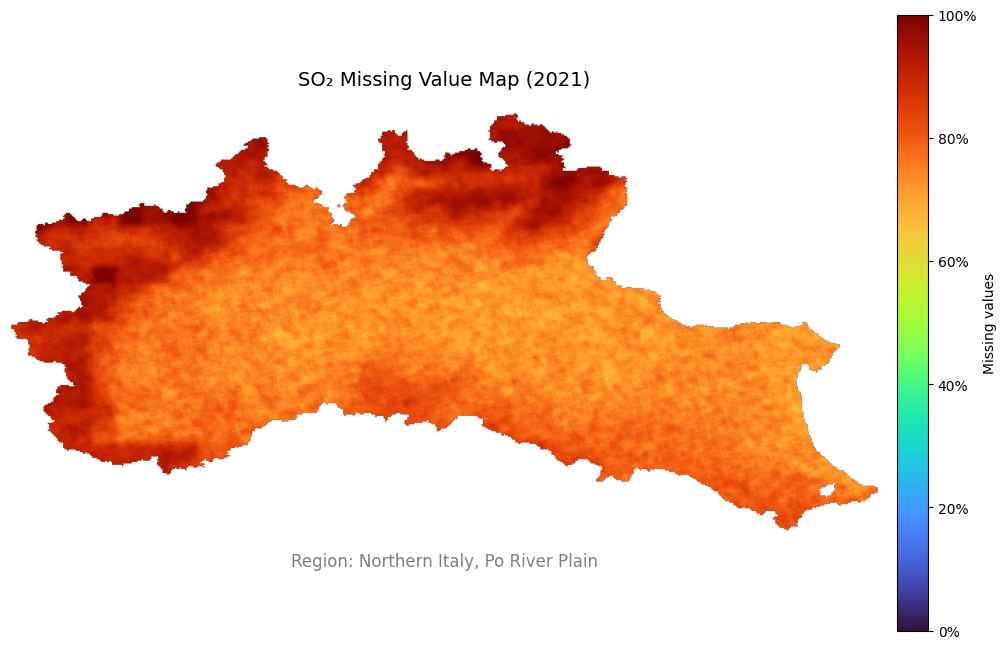


=== 2021 Gap Statistics ===
Total days: 365
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.791 (79.1%)
Median missing rate: 0.767 (76.7%)
Standard deviation: 0.075
90th percentile: 0.918 (91.8%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 66.9%
Very High (≥80%): 33.1%

=== Files Saved ===
PNG file: SO2_Missing_Value_Map_2021.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask

# Define file template
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

year = 2021
file_path = file_template.format(year)
with rasterio.open(file_path) as src:
    bands = src.read()  # shape: (days, height, width)
    print(f"{year} bands:", bands.shape)

    # 0 or nan is considered missing
    mask = (bands <= 0) | np.isnan(bands)
    yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel in 2021
    total_days = bands.shape[0]
    gap_ratio = yearly_gap / total_days   # Missing rate per pixel

    # Get spatial range and create AOI mask
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Apply AOI mask to the gap ratio
masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

# Calculate statistics
valid_data = masked_gap_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Drawing
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(masked_gap_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

ax.set_title("SO₂ Missing Value Map (2021)", fontsize=14, pad=20)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Missing_Value_Map_2021.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== 2021 Gap Statistics ===")
print(f"Total days: {total_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Missing_Value_Map_2021.png (300 DPI)")

## 7. SO₂ Missing Value Map (2022)

2022 bands: (365, 300, 621)


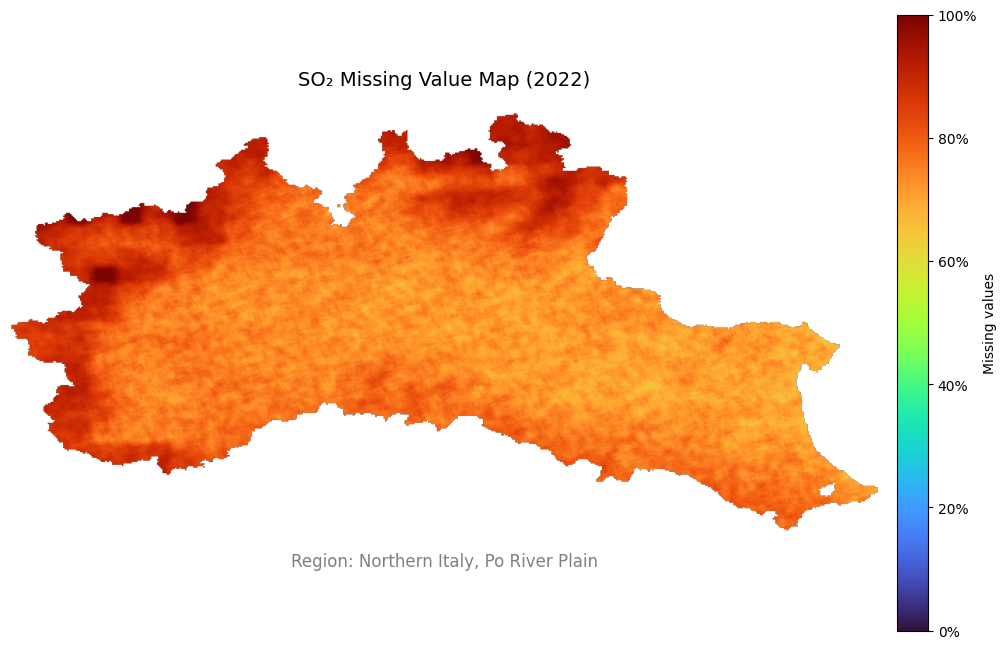


=== 2022 Gap Statistics ===
Total days: 365
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.770 (77.0%)
Median missing rate: 0.751 (75.1%)
Standard deviation: 0.066
90th percentile: 0.877 (87.7%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 75.4%
Very High (≥80%): 24.6%

=== Files Saved ===
PNG file: SO2_Missing_Value_Map_2022.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask

# Define file template
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

year = 2022
file_path = file_template.format(year)
with rasterio.open(file_path) as src:
    bands = src.read()  # shape: (days, height, width)
    print(f"{year} bands:", bands.shape)

    # 0 or nan is considered missing
    mask = (bands <= 0) | np.isnan(bands)
    yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel in 2022
    total_days = bands.shape[0]
    gap_ratio = yearly_gap / total_days   # Missing rate per pixel

    # Get spatial range and create AOI mask
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Apply AOI mask to the gap ratio
masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

# Calculate statistics
valid_data = masked_gap_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Drawing
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(masked_gap_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

ax.set_title("SO₂ Missing Value Map (2022)", fontsize=14, pad=20)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Missing_Value_Map_2022.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== 2022 Gap Statistics ===")
print(f"Total days: {total_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Missing_Value_Map_2022.png (300 DPI)")

## 8. SO₂ Missing Value Map (2023)

2023 bands: (365, 300, 621)


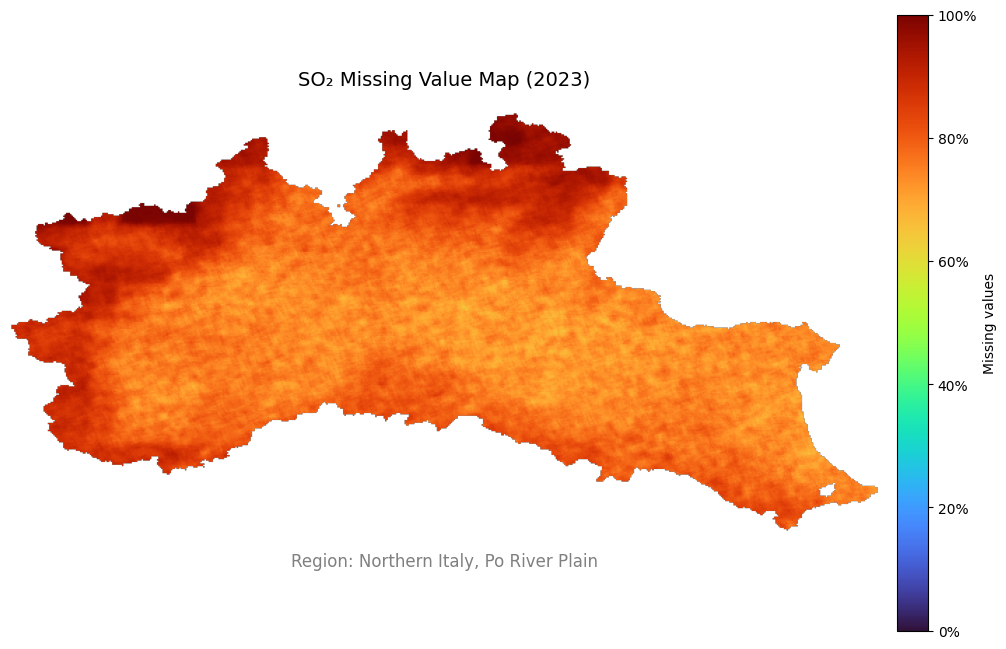


=== 2023 Gap Statistics ===
Total days: 365
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.786 (78.6%)
Median missing rate: 0.764 (76.4%)
Standard deviation: 0.067
90th percentile: 0.893 (89.3%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 68.6%
Very High (≥80%): 31.4%

=== Files Saved ===
PNG file: SO2_Missing_Value_Map_2023.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask

# Define file template
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

year = 2023
file_path = file_template.format(year)
with rasterio.open(file_path) as src:
    bands = src.read()  # shape: (days, height, width)
    print(f"{year} bands:", bands.shape)

    # 0 or nan is considered missing
    mask = (bands <= 0) | np.isnan(bands)
    yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel in 2023
    total_days = bands.shape[0]
    gap_ratio = yearly_gap / total_days   # Missing rate per pixel

    # Get spatial range and create AOI mask
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Apply AOI mask to the gap ratio
masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

# Calculate statistics
valid_data = masked_gap_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Drawing
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(masked_gap_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

ax.set_title("SO₂ Missing Value Map (2023)", fontsize=14, pad=20)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Missing_Value_Map_2023.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== 2023 Gap Statistics ===")
print(f"Total days: {total_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Missing_Value_Map_2023.png (300 DPI)")

## 9. SO₂ Spring (MAM) Missing Value Map (2019–2023)

2019 spring bands: (92, 300, 621)
2020 spring bands: (92, 300, 621)
2021 spring bands: (92, 300, 621)
2022 spring bands: (92, 300, 621)
2023 spring bands: (92, 300, 621)


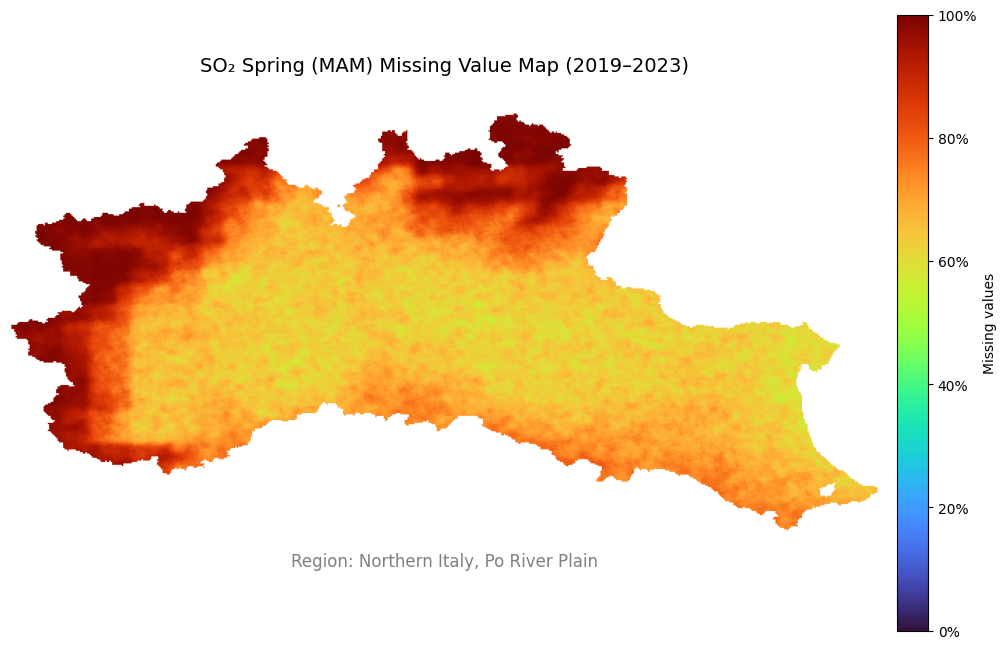


=== Spring (MAM) Gap Statistics (2019-2023) ===
Total spring days: 460
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.725 (72.5%)
Median missing rate: 0.676 (67.6%)
Standard deviation: 0.121
90th percentile: 0.957 (95.7%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 77.1%
Very High (≥80%): 22.9%

=== Files Saved ===
PNG file: SO2_Spring_Missing_Value_Map_2019_2023.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask

# Define years and file template
years = [2019, 2020, 2021, 2022, 2023]
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

# Function to get indices for March, April, May (spring) for a given year
def get_spring_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    # March 1st is the (sum of days in Jan-Feb) + 1
    mar_start = sum(days_in_month[:2])
    # April 1st is the (sum of days in Jan-Mar)
    apr_start = sum(days_in_month[:3])
    # May 1st is the (sum of days in Jan-Apr)
    may_start = sum(days_in_month[:4])
    # March indices
    mar_indices = list(range(mar_start, mar_start + days_in_month[2]))
    # April indices
    apr_indices = list(range(apr_start, apr_start + days_in_month[3]))
    # May indices
    may_indices = list(range(may_start, may_start + days_in_month[4]))
    return mar_indices + apr_indices + may_indices

# Initialize variables for gap statistics
sum_gap = None
total_spring_days = 0

for year in years:
    file_path = file_template.format(year)
    with rasterio.open(file_path) as src:
        bands = src.read()  # shape: (days, height, width)
        spring_idx = get_spring_indices(year)
        spring_bands = bands[spring_idx, :, :]
        print(f"{year} spring bands:", spring_bands.shape)

        # Missing if value <= 0 or NaN
        mask = (spring_bands <= 0) | np.isnan(spring_bands)
        yearly_gap = np.sum(mask, axis=0)  # Missing days per pixel in spring

        if sum_gap is None:
            sum_gap = yearly_gap
        else:
            sum_gap += yearly_gap

        total_spring_days += spring_bands.shape[0]

# Calculate the missing rate (no masking yet)
gap_ratio_spring = sum_gap / total_spring_days

# Get spatial extent and transform from the last year file
with rasterio.open(file_template.format(2023)) as src:
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask (True inside AOI, False outside)
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Mask outside AOI (set to masked, will show as white)
gap_ratio_spring_aoi = ma.masked_where(~aoi_mask, gap_ratio_spring)

# Calculate statistics
valid_data = gap_ratio_spring_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(gap_ratio_spring_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)
im.cmap.set_bad(color='white')  # AOI outside as white
cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

# Title with increased padding to move it further from the plot
ax.set_title("SO₂ Spring (MAM) Missing Value Map (2019–2023)", fontsize=14, pad=30)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Spring_Missing_Value_Map_2019_2023.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== Spring (MAM) Gap Statistics (2019-2023) ===")
print(f"Total spring days: {total_spring_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Spring_Missing_Value_Map_2019_2023.png (300 DPI)")

## 10. SO₂ Summer (JJA) Missing Value Map (2019–2023)

2019 summer bands: (92, 300, 621)
2020 summer bands: (92, 300, 621)
2021 summer bands: (92, 300, 621)
2022 summer bands: (92, 300, 621)
2023 summer bands: (92, 300, 621)


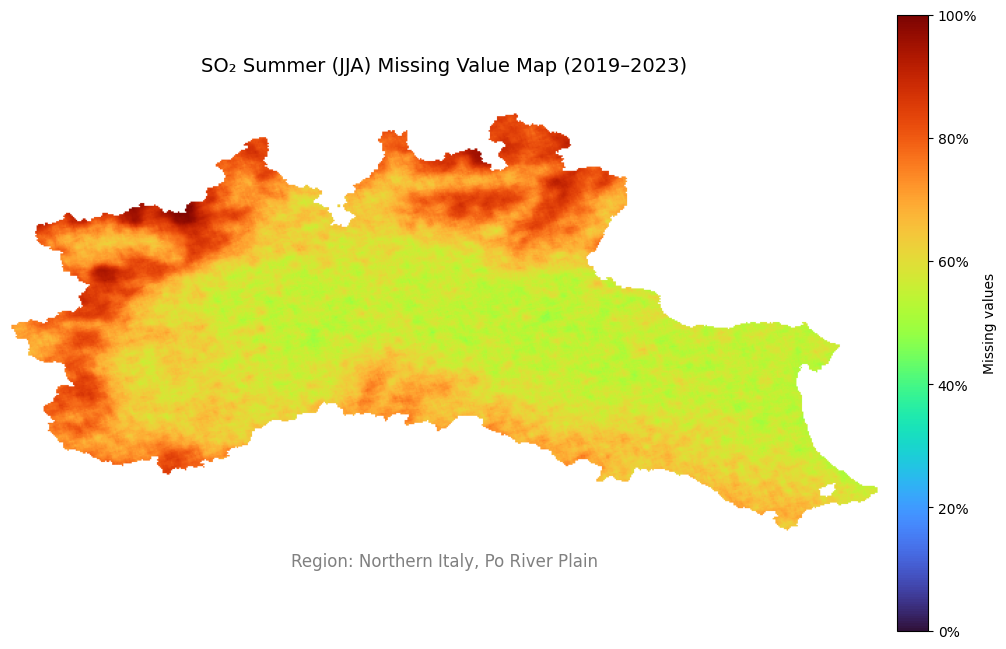


=== Summer (JJA) Gap Statistics (2019-2023) ===
Total summer days: 460
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.643 (64.3%)
Median missing rate: 0.617 (61.7%)
Standard deviation: 0.095
90th percentile: 0.793 (79.3%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.1%
High (50-80%): 90.6%
Very High (≥80%): 9.3%

=== Files Saved ===
PNG file: SO2_Summer_Missing_Value_Map_2019_2023.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask

# Define years and file template
years = [2019, 2020, 2021, 2022, 2023]
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

# Function to get indices for June, July, August (summer) for a given year
def get_summer_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    # June 1st is the (sum of days in Jan-May)
    jun_start = sum(days_in_month[:5])
    # July 1st is the (sum of days in Jan-Jun)
    jul_start = sum(days_in_month[:6])
    # August 1st is the (sum of days in Jan-Jul)
    aug_start = sum(days_in_month[:7])
    # June indices
    jun_indices = list(range(jun_start, jun_start + days_in_month[5]))
    # July indices
    jul_indices = list(range(jul_start, jul_start + days_in_month[6]))
    # August indices
    aug_indices = list(range(aug_start, aug_start + days_in_month[7]))
    return jun_indices + jul_indices + aug_indices

# Initialize variables for gap statistics
sum_gap = None
total_summer_days = 0

for year in years:
    file_path = file_template.format(year)
    with rasterio.open(file_path) as src:
        bands = src.read()  # shape: (days, height, width)
        summer_idx = get_summer_indices(year)
        summer_bands = bands[summer_idx, :, :]
        print(f"{year} summer bands:", summer_bands.shape)

        # Missing if value <= 0 or NaN
        mask = (summer_bands <= 0) | np.isnan(summer_bands)
        yearly_gap = np.sum(mask, axis=0)  # Missing days per pixel in summer

        if sum_gap is None:
            sum_gap = yearly_gap
        else:
            sum_gap += yearly_gap

        total_summer_days += summer_bands.shape[0]

# Calculate the missing rate (no masking yet)
gap_ratio_summer = sum_gap / total_summer_days

# Get spatial extent and transform from the last year file
with rasterio.open(file_template.format(2023)) as src:
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask (True inside AOI, False outside)
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Mask outside AOI (set to masked, will show as white)
gap_ratio_summer_aoi = ma.masked_where(~aoi_mask, gap_ratio_summer)

# Calculate statistics
valid_data = gap_ratio_summer_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(gap_ratio_summer_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)
im.cmap.set_bad(color='white')  # AOI outside as white
cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

# Title with increased padding to move it further from the plot
ax.set_title("SO₂ Summer (JJA) Missing Value Map (2019–2023)", fontsize=14, pad=30)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Summer_Missing_Value_Map_2019_2023.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== Summer (JJA) Gap Statistics (2019-2023) ===")
print(f"Total summer days: {total_summer_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Summer_Missing_Value_Map_2019_2023.png (300 DPI)")

## 11. SO₂ Autumn (SON) Missing Value Map (2019–2023)

2019 autumn bands: (91, 300, 621)
2020 autumn bands: (91, 300, 621)
2021 autumn bands: (91, 300, 621)
2022 autumn bands: (91, 300, 621)
2023 autumn bands: (91, 300, 621)


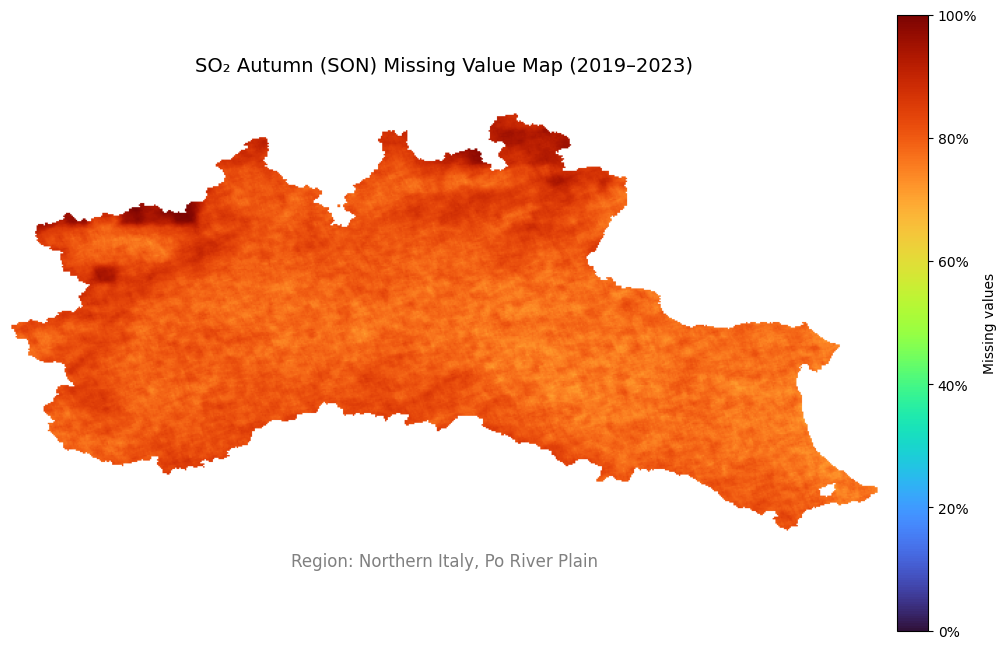


=== Autumn (SON) Gap Statistics (2019-2023) ===
Total autumn days: 455
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.800 (80.0%)
Median missing rate: 0.793 (79.3%)
Standard deviation: 0.039
90th percentile: 0.846 (84.6%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 56.0%
Very High (≥80%): 44.0%

=== Files Saved ===
PNG file: SO2_Autumn_Missing_Value_Map_2019_2023.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask

# Define years and file template
years = [2019, 2020, 2021, 2022, 2023]
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

# Function to get indices for September, October, November (autumn) for a given year
def get_autumn_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    # September 1st is the (sum of days in Jan-Aug)
    sep_start = sum(days_in_month[:8])
    # October 1st is the (sum of days in Jan-Sep)
    oct_start = sum(days_in_month[:9])
    # November 1st is the (sum of days in Jan-Oct)
    nov_start = sum(days_in_month[:10])
    # September indices
    sep_indices = list(range(sep_start, sep_start + days_in_month[8]))
    # October indices
    oct_indices = list(range(oct_start, oct_start + days_in_month[9]))
    # November indices
    nov_indices = list(range(nov_start, nov_start + days_in_month[10]))
    return sep_indices + oct_indices + nov_indices

# Initialize variables for gap statistics
sum_gap = None
total_autumn_days = 0

for year in years:
    file_path = file_template.format(year)
    with rasterio.open(file_path) as src:
        bands = src.read()  # shape: (days, height, width)
        autumn_idx = get_autumn_indices(year)
        autumn_bands = bands[autumn_idx, :, :]
        print(f"{year} autumn bands:", autumn_bands.shape)

        # Missing if value <= 0 or NaN
        mask = (autumn_bands <= 0) | np.isnan(autumn_bands)
        yearly_gap = np.sum(mask, axis=0)  # Missing days per pixel in autumn

        if sum_gap is None:
            sum_gap = yearly_gap
        else:
            sum_gap += yearly_gap

        total_autumn_days += autumn_bands.shape[0]

# Calculate the missing rate (no masking yet)
gap_ratio_autumn = sum_gap / total_autumn_days

# Get spatial extent and transform from the last year file
with rasterio.open(file_template.format(2023)) as src:
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask (True inside AOI, False outside)
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Mask outside AOI (set to masked, will show as white)
gap_ratio_autumn_aoi = ma.masked_where(~aoi_mask, gap_ratio_autumn)

# Calculate statistics
valid_data = gap_ratio_autumn_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(gap_ratio_autumn_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)
im.cmap.set_bad(color='white')  # AOI outside as white
cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

# Title with increased padding to move it further from the plot
ax.set_title("SO₂ Autumn (SON) Missing Value Map (2019–2023)", fontsize=14, pad=30)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Autumn_Missing_Value_Map_2019_2023.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== Autumn (SON) Gap Statistics (2019-2023) ===")
print(f"Total autumn days: {total_autumn_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Autumn_Missing_Value_Map_2019_2023.png (300 DPI)")

## 12. SO₂ Winter (DJF) Missing Value Map (2019–2023)

2019 winter bands: (90, 300, 621)
2020 winter bands: (91, 300, 621)
2021 winter bands: (90, 300, 621)
2022 winter bands: (90, 300, 621)
2023 winter bands: (90, 300, 621)


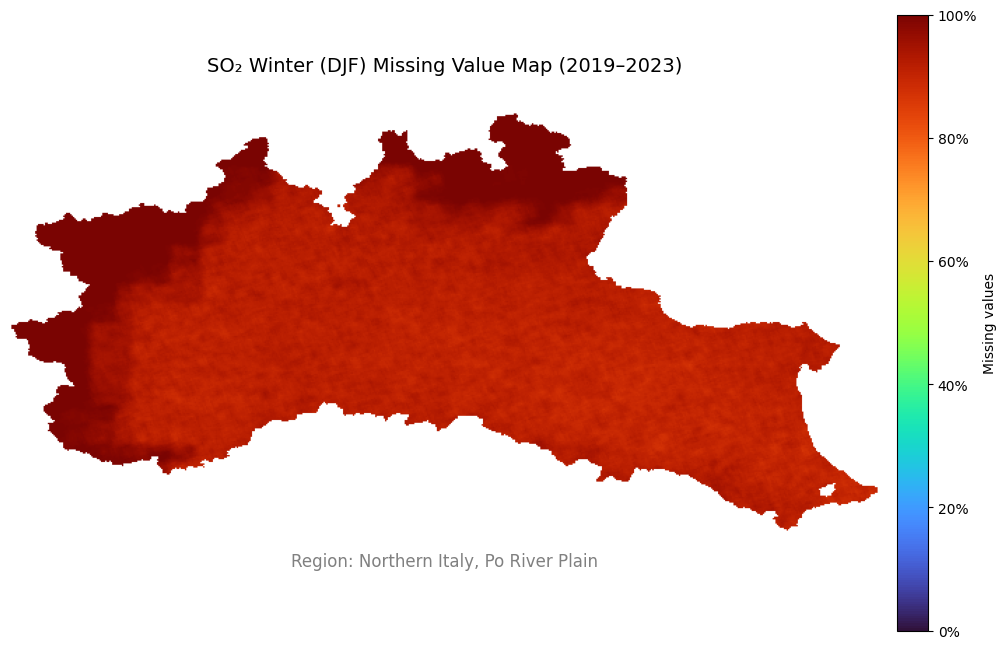


=== Winter (DJF) Gap Statistics (2019-2023) ===
Total winter days: 451
Valid pixels: 94666

Missing rate statistics:
Mean missing rate: 0.931 (93.1%)
Median missing rate: 0.918 (91.8%)
Standard deviation: 0.035
90th percentile: 1.000 (100.0%)

Missing rate categories:
Low (<20%): 0.0%
Medium (20-50%): 0.0%
High (50-80%): 0.0%
Very High (≥80%): 100.0%

=== Files Saved ===
PNG file: SO2_Winter_Missing_Value_Map_2019_2023.png (300 DPI)


In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask

# Define years and file template
years = [2019, 2020, 2021, 2022, 2023]
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

# Function to get indices for December, January, February (winter) for a given year
def get_winter_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    # December 1st is the (sum of days in Jan-Nov)
    dec_start = sum(days_in_month[:11])
    # January 1st is day 0 (first day of the year)
    jan_start = 0
    # February 1st is the (days in January)
    feb_start = days_in_month[0]
    # December indices
    dec_indices = list(range(dec_start, dec_start + days_in_month[11]))
    # January indices
    jan_indices = list(range(jan_start, jan_start + days_in_month[0]))
    # February indices
    feb_indices = list(range(feb_start, feb_start + days_in_month[1]))
    return dec_indices + jan_indices + feb_indices

# Initialize variables for gap statistics
sum_gap = None
total_winter_days = 0

for year in years:
    file_path = file_template.format(year)
    with rasterio.open(file_path) as src:
        bands = src.read()  # shape: (days, height, width)
        winter_idx = get_winter_indices(year)
        winter_bands = bands[winter_idx, :, :]
        print(f"{year} winter bands:", winter_bands.shape)

        # Missing if value <= 0 or NaN
        mask = (winter_bands <= 0) | np.isnan(winter_bands)
        yearly_gap = np.sum(mask, axis=0)  # Missing days per pixel in winter

        if sum_gap is None:
            sum_gap = yearly_gap
        else:
            sum_gap += yearly_gap

        total_winter_days += winter_bands.shape[0]

# Calculate the missing rate (no masking yet)
gap_ratio_winter = sum_gap / total_winter_days

# Get spatial extent and transform from the last year file
with rasterio.open(file_template.format(2023)) as src:
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask (True inside AOI, False outside)
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Mask outside AOI (set to masked, will show as white)
gap_ratio_winter_aoi = ma.masked_where(~aoi_mask, gap_ratio_winter)

# Calculate statistics
valid_data = gap_ratio_winter_aoi.compressed()
total_valid_pixels = len(valid_data)

mean_missing = np.mean(valid_data)
median_missing = np.median(valid_data)
std_missing = np.std(valid_data)
p90 = np.percentile(valid_data, 90)

# Missing rate categories
low_missing = np.sum(valid_data < 0.2)
medium_missing = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
high_missing = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
very_high_missing = np.sum(valid_data >= 0.8)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(gap_ratio_winter_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)
im.cmap.set_bad(color='white')  # AOI outside as white
cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.02)

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])
cbar.set_label("Missing values")

# Title with increased padding to move it further from the plot
ax.set_title("SO₂ Winter (DJF) Missing Value Map (2019–2023)", fontsize=14, pad=30)
ax.annotate(
    'Region: Northern Italy, Po River Plain',
    xy=(0.5, -0.08), xycoords='axes fraction',
    ha='center', fontsize=12, color='gray'
)
ax.axis('off')

# Save the figure with high quality
plt.savefig('SO2_Winter_Missing_Value_Map_2019_2023.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print statistics
print(f"\n=== Winter (DJF) Gap Statistics (2019-2023) ===")
print(f"Total winter days: {total_winter_days}")
print(f"Valid pixels: {total_valid_pixels}")
print(f"\nMissing rate statistics:")
print(f"Mean missing rate: {mean_missing:.3f} ({mean_missing*100:.1f}%)")
print(f"Median missing rate: {median_missing:.3f} ({median_missing*100:.1f}%)")
print(f"Standard deviation: {std_missing:.3f}")
print(f"90th percentile: {p90:.3f} ({p90*100:.1f}%)")
print(f"\nMissing rate categories:")
print(f"Low (<20%): {low_missing/total_valid_pixels*100:.1f}%")
print(f"Medium (20-50%): {medium_missing/total_valid_pixels*100:.1f}%")
print(f"High (50-80%): {high_missing/total_valid_pixels*100:.1f}%")
print(f"Very High (≥80%): {very_high_missing/total_valid_pixels*100:.1f}%")

print(f"\n=== Files Saved ===")
print(f"PNG file: SO2_Winter_Missing_Value_Map_2019_2023.png (300 DPI)")

## 13. SO₂ Comprehensive Statistics(5 Years/Each Year/Season)

In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd
from tabulate import tabulate

# Define years and file template
years = [2019, 2020, 2021, 2022, 2023]
file_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

# Function to get seasonal indices
def get_spring_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    mar_start = sum(days_in_month[:2])
    apr_start = sum(days_in_month[:3])
    may_start = sum(days_in_month[:4])
    mar_indices = list(range(mar_start, mar_start + days_in_month[2]))
    apr_indices = list(range(apr_start, apr_start + days_in_month[3]))
    may_indices = list(range(may_start, may_start + days_in_month[4]))
    return mar_indices + apr_indices + may_indices

def get_summer_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    jun_start = sum(days_in_month[:5])
    jul_start = sum(days_in_month[:6])
    aug_start = sum(days_in_month[:7])
    jun_indices = list(range(jun_start, jun_start + days_in_month[5]))
    jul_indices = list(range(jul_start, jul_start + days_in_month[6]))
    aug_indices = list(range(aug_start, aug_start + days_in_month[7]))
    return jun_indices + jul_indices + aug_indices

def get_autumn_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    sep_start = sum(days_in_month[:8])
    oct_start = sum(days_in_month[:9])
    nov_start = sum(days_in_month[:10])
    sep_indices = list(range(sep_start, sep_start + days_in_month[8]))
    oct_indices = list(range(oct_start, oct_start + days_in_month[9]))
    nov_indices = list(range(nov_start, nov_start + days_in_month[10]))
    return sep_indices + oct_indices + nov_indices

def get_winter_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    dec_start = sum(days_in_month[:11])
    jan_start = 0
    feb_start = days_in_month[0]
    dec_indices = list(range(dec_start, dec_start + days_in_month[11]))
    jan_indices = list(range(jan_start, jan_start + days_in_month[0]))
    feb_indices = list(range(feb_start, feb_start + days_in_month[1]))
    return dec_indices + jan_indices + feb_indices

# Get spatial extent and transform
with rasterio.open(file_template.format(2023)) as src:
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    transform = src.transform
    out_shape = (src.height, src.width)

# Create AOI mask
aoi_mask = geometry_mask([aoi.geometry.union_all()],
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

# Initialize results storage
results = {
    '5_year': {},
    'annual': {},
    'seasonal': {}
}

# 1. 5-Year Overall Statistics
print("Calculating 5-year overall statistics...")
sum_gap_5yr = None
total_days_5yr = 0

for year in years:
    file_path = file_template.format(year)
    with rasterio.open(file_path) as src:
        bands = src.read()
        mask = (bands <= 0) | np.isnan(bands)
        yearly_gap = np.sum(mask, axis=0)

        if sum_gap_5yr is None:
            sum_gap_5yr = yearly_gap
        else:
            sum_gap_5yr += yearly_gap

        total_days_5yr += bands.shape[0]

gap_ratio_5yr = sum_gap_5yr / total_days_5yr
gap_ratio_5yr_aoi = ma.masked_where(~aoi_mask, gap_ratio_5yr)
valid_data_5yr = gap_ratio_5yr_aoi.compressed()

results['5_year'] = {
    'total_days': total_days_5yr,
    'valid_pixels': len(valid_data_5yr),
    'mean_missing': np.mean(valid_data_5yr),
    'median_missing': np.median(valid_data_5yr),
    'std_missing': np.std(valid_data_5yr),
    'p90': np.percentile(valid_data_5yr, 90),
    'low_missing': np.sum(valid_data_5yr < 0.2),
    'medium_missing': np.sum((valid_data_5yr >= 0.2) & (valid_data_5yr < 0.5)),
    'high_missing': np.sum((valid_data_5yr >= 0.5) & (valid_data_5yr < 0.8)),
    'very_high_missing': np.sum(valid_data_5yr >= 0.8)
}

# 2. Annual Statistics
print("Calculating annual statistics...")
for year in years:
    file_path = file_template.format(year)
    with rasterio.open(file_path) as src:
        bands = src.read()
        mask = (bands <= 0) | np.isnan(bands)
        yearly_gap = np.sum(mask, axis=0)
        gap_ratio = yearly_gap / bands.shape[0]
        gap_ratio_aoi = ma.masked_where(~aoi_mask, gap_ratio)
        valid_data = gap_ratio_aoi.compressed()

        results['annual'][year] = {
            'total_days': bands.shape[0],
            'valid_pixels': len(valid_data),
            'mean_missing': np.mean(valid_data),
            'median_missing': np.median(valid_data),
            'std_missing': np.std(valid_data),
            'p90': np.percentile(valid_data, 90),
            'low_missing': np.sum(valid_data < 0.2),
            'medium_missing': np.sum((valid_data >= 0.2) & (valid_data < 0.5)),
            'high_missing': np.sum((valid_data >= 0.5) & (valid_data < 0.8)),
            'very_high_missing': np.sum(valid_data >= 0.8)
        }

# 3. Seasonal Statistics
print("Calculating seasonal statistics...")
seasons = {
    'Spring': get_spring_indices,
    'Summer': get_summer_indices,
    'Autumn': get_autumn_indices,
    'Winter': get_winter_indices
}

for season_name, season_func in seasons.items():
    sum_gap_season = None
    total_days_season = 0

    for year in years:
        file_path = file_template.format(year)
        with rasterio.open(file_path) as src:
            bands = src.read()
            season_idx = season_func(year)
            season_bands = bands[season_idx, :, :]

            mask = (season_bands <= 0) | np.isnan(season_bands)
            yearly_gap = np.sum(mask, axis=0)

            if sum_gap_season is None:
                sum_gap_season = yearly_gap
            else:
                sum_gap_season += yearly_gap

            total_days_season += season_bands.shape[0]

    gap_ratio_season = sum_gap_season / total_days_season
    gap_ratio_season_aoi = ma.masked_where(~aoi_mask, gap_ratio_season)
    valid_data_season = gap_ratio_season_aoi.compressed()

    results['seasonal'][season_name] = {
        'total_days': total_days_season,
        'valid_pixels': len(valid_data_season),
        'mean_missing': np.mean(valid_data_season),
        'median_missing': np.median(valid_data_season),
        'std_missing': np.std(valid_data_season),
        'p90': np.percentile(valid_data_season, 90),
        'low_missing': np.sum(valid_data_season < 0.2),
        'medium_missing': np.sum((valid_data_season >= 0.2) & (valid_data_season < 0.5)),
        'high_missing': np.sum((valid_data_season >= 0.5) & (valid_data_season < 0.8)),
        'very_high_missing': np.sum(valid_data_season >= 0.8)
    }

# Create tables
print("\n" + "="*80)
print("SO₂ MISSING VALUE STATISTICS (2019-2023)")
print("="*80)

# 1. 5-Year Overall Table
print("\n1. 5-YEAR OVERALL STATISTICS")
print("-" * 50)
overall_data = results['5_year']
overall_table = [
    ["Total Days", f"{overall_data['total_days']}"],
    ["Valid Pixels", f"{overall_data['valid_pixels']:,}"],
    ["Mean Missing Rate", f"{overall_data['mean_missing']:.3f} ({overall_data['mean_missing']*100:.1f}%)"],
    ["Median Missing Rate", f"{overall_data['median_missing']:.3f} ({overall_data['median_missing']*100:.1f}%)"],
    ["Standard Deviation", f"{overall_data['std_missing']:.3f}"],
    ["90th Percentile", f"{overall_data['p90']:.3f} ({overall_data['p90']*100:.1f}%)"],
    ["Low (<20%)", f"{overall_data['low_missing']:,} ({overall_data['low_missing']/overall_data['valid_pixels']*100:.1f}%)"],
    ["Medium (20-50%)", f"{overall_data['medium_missing']:,} ({overall_data['medium_missing']/overall_data['valid_pixels']*100:.1f}%)"],
    ["High (50-80%)", f"{overall_data['high_missing']:,} ({overall_data['high_missing']/overall_data['valid_pixels']*100:.1f}%)"],
    ["Very High (≥80%)", f"{overall_data['very_high_missing']:,} ({overall_data['very_high_missing']/overall_data['valid_pixels']*100:.1f}%)"]
]
print(tabulate(overall_table, headers=["Metric", "Value"], tablefmt="grid"))

# 2. Annual Statistics Table
print("\n2. ANNUAL STATISTICS")
print("-" * 50)
annual_headers = ["Year", "Days", "Valid Pixels", "Mean (%)", "Median (%)", "Std Dev", "P90 (%)", "Low (%)", "Medium (%)", "High (%)", "Very High (%)"]
annual_table = []

for year in years:
    data = results['annual'][year]
    annual_table.append([
        year,
        data['total_days'],
        f"{data['valid_pixels']:,}",
        f"{data['mean_missing']*100:.1f}",
        f"{data['median_missing']*100:.1f}",
        f"{data['std_missing']:.3f}",
        f"{data['p90']*100:.1f}",
        f"{data['low_missing']/data['valid_pixels']*100:.1f}",
        f"{data['medium_missing']/data['valid_pixels']*100:.1f}",
        f"{data['high_missing']/data['valid_pixels']*100:.1f}",
        f"{data['very_high_missing']/data['valid_pixels']*100:.1f}"
    ])

print(tabulate(annual_table, headers=annual_headers, tablefmt="grid"))

# 3. Seasonal Statistics Table
print("\n3. SEASONAL STATISTICS")
print("-" * 50)
seasonal_headers = ["Season", "Days", "Valid Pixels", "Mean (%)", "Median (%)", "Std Dev", "P90 (%)", "Low (%)", "Medium (%)", "High (%)", "Very High (%)"]
seasonal_table = []

for season_name in ['Spring', 'Summer', 'Autumn', 'Winter']:
    data = results['seasonal'][season_name]
    seasonal_table.append([
        season_name,
        data['total_days'],
        f"{data['valid_pixels']:,}",
        f"{data['mean_missing']*100:.1f}",
        f"{data['median_missing']*100:.1f}",
        f"{data['std_missing']:.3f}",
        f"{data['p90']*100:.1f}",
        f"{data['low_missing']/data['valid_pixels']*100:.1f}",
        f"{data['medium_missing']/data['valid_pixels']*100:.1f}",
        f"{data['high_missing']/data['valid_pixels']*100:.1f}",
        f"{data['very_high_missing']/data['valid_pixels']*100:.1f}"
    ])

print(tabulate(seasonal_table, headers=seasonal_headers, tablefmt="grid"))

# Save results to CSV
print("\n4. SAVING RESULTS TO CSV FILES")
print("-" * 50)

# Annual CSV
annual_df = pd.DataFrame(annual_table, columns=annual_headers)
annual_df.to_csv('SO2_Annual_Statistics_2019_2023.csv', index=False)
print("Annual statistics saved to: SO2_Annual_Statistics_2019_2023.csv")

# Seasonal CSV
seasonal_df = pd.DataFrame(seasonal_table, columns=seasonal_headers)
seasonal_df.to_csv('SO2_Seasonal_Statistics_2019_2023.csv', index=False)
print("Seasonal statistics saved to: SO2_Seasonal_Statistics_2019_2023.csv")

# Overall CSV
overall_df = pd.DataFrame(overall_table, columns=["Metric", "Value"])
overall_df.to_csv('SO2_Overall_Statistics_2019_2023.csv', index=False)
print("Overall statistics saved to: SO2_Overall_Statistics_2019_2023.csv")

print("\n" + "="*80)
print("SO₂ STATISTICS COMPLETED!")
print("="*80)

Calculating 5-year overall statistics...
Calculating annual statistics...
Calculating seasonal statistics...

SO₂ MISSING VALUE STATISTICS (2019-2023)

1. 5-YEAR OVERALL STATISTICS
--------------------------------------------------
+---------------------+----------------+
| Metric              | Value          |
+=====================+================+
| Total Days          | 1826           |
+---------------------+----------------+
| Valid Pixels        | 94,666         |
+---------------------+----------------+
| Mean Missing Rate   | 0.774 (77.4%)  |
+---------------------+----------------+
| Median Missing Rate | 0.749 (74.9%)  |
+---------------------+----------------+
| Standard Deviation  | 0.068          |
+---------------------+----------------+
| 90th Percentile     | 0.889 (88.9%)  |
+---------------------+----------------+
| Low (<20%)          | 0 (0.0%)       |
+---------------------+----------------+
| Medium (20-50%)     | 0 (0.0%)       |
+---------------------+-------

## 14. NO₂ & SO₂ Comprehensive Statistics(5 Years/Each Year/Season)

In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask
from tabulate import tabulate

# Define years and file templates
years = [2019, 2020, 2021, 2022, 2023]
no2_template = '/gdrive/My Drive/GEE_NO2/NO2_Daily_Multiband_{}.tif'
so2_template = '/gdrive/My Drive/GEE_SO2/SO2_Daily_Multiband_{}.tif'

# Path to AOI shapefile
aoi_path = '/gdrive/My Drive/AOI/delimitazione_distretto.shp'
aoi = gpd.read_file(aoi_path)

# Seasonal index functions
def get_spring_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    mar_start = sum(days_in_month[:2])
    apr_start = sum(days_in_month[:3])
    may_start = sum(days_in_month[:4])
    mar_indices = list(range(mar_start, mar_start + days_in_month[2]))
    apr_indices = list(range(apr_start, apr_start + days_in_month[3]))
    may_indices = list(range(may_start, may_start + days_in_month[4]))
    return mar_indices + apr_indices + may_indices

def get_summer_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    jun_start = sum(days_in_month[:5])
    jul_start = sum(days_in_month[:6])
    aug_start = sum(days_in_month[:7])
    jun_indices = list(range(jun_start, jun_start + days_in_month[5]))
    jul_indices = list(range(jul_start, jul_start + days_in_month[6]))
    aug_indices = list(range(aug_start, aug_start + days_in_month[7]))
    return jun_indices + jul_indices + aug_indices

def get_autumn_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    sep_start = sum(days_in_month[:8])
    oct_start = sum(days_in_month[:9])
    nov_start = sum(days_in_month[:10])
    sep_indices = list(range(sep_start, sep_start + days_in_month[8]))
    oct_indices = list(range(oct_start, oct_start + days_in_month[9]))
    nov_indices = list(range(nov_start, nov_start + days_in_month[10]))
    return sep_indices + oct_indices + nov_indices

def get_winter_indices(year):
    days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
    dec_indices = list(range(sum(days_in_month[:11]), sum(days_in_month[:12])))
    jan_indices = list(range(days_in_month[0]))
    feb_indices = list(range(days_in_month[0], days_in_month[0] + days_in_month[1]))
    return dec_indices + jan_indices + feb_indices

# Function to calculate average missing rate for a given pollutant
def calculate_average_missing(file_template, pollutant_name):

    # Get spatial extent and transform
    with rasterio.open(file_template.format(2023)) as src:
        transform = src.transform
        out_shape = (src.height, src.width)

    # Create AOI mask
    aoi_mask = geometry_mask([aoi.geometry.union_all()],
                            transform=transform,
                            invert=True,
                            out_shape=out_shape)

    # Initialize variables
    sum_gap = None
    total_days = 0

    for year in years:
        file_path = file_template.format(year)
        with rasterio.open(file_path) as src:
            bands = src.read()
            mask = (bands <= 0) | np.isnan(bands)
            yearly_gap = np.sum(mask, axis=0)

            if sum_gap is None:
                sum_gap = yearly_gap
            else:
                sum_gap += yearly_gap

            total_days += bands.shape[0]

    gap_ratio = sum_gap / total_days
    gap_ratio_aoi = ma.masked_where(~aoi_mask, gap_ratio)
    valid_data = gap_ratio_aoi.compressed()

    return np.mean(valid_data)

# Function to calculate seasonal missing rates for a given pollutant
def calculate_seasonal_missing(file_template, pollutant_name):

    # Get spatial extent and transform
    with rasterio.open(file_template.format(2023)) as src:
        transform = src.transform
        out_shape = (src.height, src.width)

    # Create AOI mask
    aoi_mask = geometry_mask([aoi.geometry.union_all()],
                            transform=transform,
                            invert=True,
                            out_shape=out_shape)

    seasonal_stats = {'spring': [], 'summer': [], 'autumn': [], 'winter': []}

    for year in years:
        file_path = file_template.format(year)
        with rasterio.open(file_path) as src:
            bands = src.read()

            # Calculate seasonal missing rates
            spring_indices = get_spring_indices(year)
            summer_indices = get_summer_indices(year)
            autumn_indices = get_autumn_indices(year)
            winter_indices = get_winter_indices(year)

            # Spring (MAM)
            spring_bands = bands[spring_indices]
            spring_mask = (spring_bands <= 0) | np.isnan(spring_bands)
            spring_gap = np.sum(spring_mask, axis=0) / len(spring_indices)
            spring_gap_aoi = ma.masked_where(~aoi_mask, spring_gap)
            seasonal_stats['spring'].append(np.mean(spring_gap_aoi.compressed()))

            # Summer (JJA)
            summer_bands = bands[summer_indices]
            summer_mask = (summer_bands <= 0) | np.isnan(summer_bands)
            summer_gap = np.sum(summer_mask, axis=0) / len(summer_indices)
            summer_gap_aoi = ma.masked_where(~aoi_mask, summer_gap)
            seasonal_stats['summer'].append(np.mean(summer_gap_aoi.compressed()))

            # Autumn (SON)
            autumn_bands = bands[autumn_indices]
            autumn_mask = (autumn_bands <= 0) | np.isnan(autumn_bands)
            autumn_gap = np.sum(autumn_mask, axis=0) / len(autumn_indices)
            autumn_gap_aoi = ma.masked_where(~aoi_mask, autumn_gap)
            seasonal_stats['autumn'].append(np.mean(autumn_gap_aoi.compressed()))

            # Winter (DJF)
            winter_bands = bands[winter_indices]
            winter_mask = (winter_bands <= 0) | np.isnan(winter_bands)
            winter_gap = np.sum(winter_mask, axis=0) / len(winter_indices)
            winter_gap_aoi = ma.masked_where(~aoi_mask, winter_gap)
            seasonal_stats['winter'].append(np.mean(winter_gap_aoi.compressed()))

    return {season: np.mean(values) for season, values in seasonal_stats.items()}

# Calculate statistics for both pollutants
print("="*80)
print("NO₂ vs SO₂ MISSING VALUE COMPARISON (2019-2023)")
print("="*80)

no2_avg = calculate_average_missing(no2_template, "NO₂")
so2_avg = calculate_average_missing(so2_template, "SO₂")

no2_seasonal = calculate_seasonal_missing(no2_template, "NO₂")
so2_seasonal = calculate_seasonal_missing(so2_template, "SO₂")

# Create comparison tables
print("\n" + "="*80)
print("AVERAGE MISSING RATE COMPARISON")
print("="*80)

avg_table = [
    ["NO₂", f"{no2_avg*100:.1f}%"],
    ["SO₂", f"{so2_avg*100:.1f}%"]
]

print(tabulate(avg_table, headers=["Pollutant", "Average Missing Rate (2019-2023)"], tablefmt="grid"))

print("\n" + "="*80)
print("SEASONAL MISSING RATE COMPARISON")
print("="*80)

seasonal_table = [
    ["Spring (MAM)", f"{no2_seasonal['spring']*100:.1f}%", f"{so2_seasonal['spring']*100:.1f}%"],
    ["Summer (JJA)", f"{no2_seasonal['summer']*100:.1f}%", f"{so2_seasonal['summer']*100:.1f}%"],
    ["Autumn (SON)", f"{no2_seasonal['autumn']*100:.1f}%", f"{so2_seasonal['autumn']*100:.1f}%"],
    ["Winter (DJF)", f"{no2_seasonal['winter']*100:.1f}%", f"{so2_seasonal['winter']*100:.1f}%"]
]

print(tabulate(seasonal_table, headers=["Season", "NO₂", "SO₂"], tablefmt="grid"))

# Summary analysis
print("\n" + "="*80)
print("SUMMARY ANALYSIS")
print("="*80)

if no2_avg > so2_avg:
    print(f"• NO₂ has {(no2_avg - so2_avg)*100:.1f}% higher average missing rate than SO₂")
else:
    print(f"• SO₂ has {(so2_avg - no2_avg)*100:.1f}% higher average missing rate than NO₂")

# Find seasons with highest differences
seasonal_diffs = {
    'Spring': no2_seasonal['spring'] - so2_seasonal['spring'],
    'Summer': no2_seasonal['summer'] - so2_seasonal['summer'],
    'Autumn': no2_seasonal['autumn'] - so2_seasonal['autumn'],
    'Winter': no2_seasonal['winter'] - so2_seasonal['winter']
}

max_diff_season = max(seasonal_diffs, key=seasonal_diffs.get)
min_diff_season = min(seasonal_diffs, key=seasonal_diffs.get)

print(f"• Largest seasonal difference: {max_diff_season} ({(seasonal_diffs[max_diff_season])*100:+.1f}%)")
print(f"• Smallest seasonal difference: {min_diff_season} ({(seasonal_diffs[min_diff_season])*100:+.1f}%)")

# Add visual comparison with simple text-based bars
print("\n" + "="*80)
print("VISUAL COMPARISON")
print("="*80)

def create_bar_chart(no2_val, so2_val, title):
    max_val = max(no2_val, so2_val)
    no2_bar_length = int((no2_val / max_val) * 30)
    so2_bar_length = int((so2_val / max_val) * 30)

    print(f"\n{title}:")
    print(f"NO₂  {'█' * no2_bar_length} {no2_val:.1f}%")
    print(f"SO₂  {'█' * so2_bar_length} {so2_val:.1f}%")

# Overall comparison
create_bar_chart(no2_avg*100, so2_avg*100, "Overall Average (2019-2023)")

# Seasonal comparisons
create_bar_chart(no2_seasonal['spring']*100, so2_seasonal['spring']*100, "Spring (MAM)")
create_bar_chart(no2_seasonal['summer']*100, so2_seasonal['summer']*100, "Summer (JJA)")
create_bar_chart(no2_seasonal['autumn']*100, so2_seasonal['autumn']*100, "Autumn (SON)")
create_bar_chart(no2_seasonal['winter']*100, so2_seasonal['winter']*100, "Winter (DJF)")

print("\n" + "="*80)
print("COMPARISON COMPLETED!")
print("="*80)

NO₂ vs SO₂ MISSING VALUE COMPARISON (2019-2023)

AVERAGE MISSING RATE COMPARISON
+-------------+------------------------------------+
| Pollutant   | Average Missing Rate (2019-2023)   |
+=============+====================================+
| NO₂         | 45.4%                              |
+-------------+------------------------------------+
| SO₂         | 77.4%                              |
+-------------+------------------------------------+

SEASONAL MISSING RATE COMPARISON
+--------------+-------+-------+
| Season       | NO₂   | SO₂   |
+==============+=======+=======+
| Spring (MAM) | 46.0% | 72.5% |
+--------------+-------+-------+
| Summer (JJA) | 35.6% | 64.3% |
+--------------+-------+-------+
| Autumn (SON) | 47.5% | 80.0% |
+--------------+-------+-------+
| Winter (DJF) | 52.7% | 93.1% |
+--------------+-------+-------+

SUMMARY ANALYSIS
• SO₂ has 32.0% higher average missing rate than NO₂
• Largest seasonal difference: Spring (-26.6%)
• Smallest seasonal difference: W